Imports for whole project

In [ ]:
import os
import random

import pandas as pd
import numpy as np

import cv2

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Convolution2D,BatchNormalization, Flatten,MaxPooling2D,Dropout
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split


## Connect to Google Drive

In [ ]:
# Connect to google drive
from google.colab import drive
drive.mount('/content/gdrive')

#https://medium.com/analytics-vidhya/how-to-fetch-kaggle-datasets-into-google-colab-ea682569851a
#https://neptune.ai/blog/google-colab-dealing-with-files

Mounted at /content/gdrive


In [ ]:
# Changing the working directory to where is the path where kaggle.json is present in the Google Drive
%cd /content/gdrive/My Drive/Kaggle

# Check what's in there
!ls

# import os
# os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

/content/gdrive/My Drive/Kaggle
kaggle.json  model.h5  test  train  validation


## Get dataset from Kaggle

In [ ]:
# Find datasets in kaggle concerning vegetables
!kaggle datasets list -s vegetable

In [ ]:
# Download dataset from kaggle (will be a zipped folder)
!kaggle datasets download -d kritikseth/fruit-and-vegetable-image-recognition

In [ ]:
# Unzip the zip files and deleting the zip files
!unzip \*.zip  && rm *.zip

# Check what's in there
!ls

## Get DIR

In [ ]:
# Set directory path to where main dataset folder is found and list subfolder names
DIR = '/content/gdrive/My Drive/Kaggle'
train_folder_names = [entry for entry in os.listdir(f'{DIR}/train')]
test_folder_names = [entry for entry in os.listdir(f'{DIR}/test')]
print('Train:', train_folder_names)
print('Test:', test_folder_names)

# Note: 'output' folder was created at a later step during image augmentation
if 'output' in train_folder_names:
  train_folder_names.remove('output')
if 'output' in test_folder_names:
  test_folder_names.remove('output')

num_classes = len(train_folder_names)
print(f"Number of classes: {num_classes}")

Train: ['apple', 'banana', 'beetroot', 'bell pepper', 'cabbage', 'capsicum', 'carrot', 'cauliflower', 'chilli pepper', 'corn', 'cucumber', 'eggplant', 'garlic', 'ginger', 'grapes', 'jalepeno', 'kiwi', 'lemon', 'lettuce', 'mango', 'onion', 'orange', 'paprika', 'pear', 'peas', 'pineapple', 'pomegranate', 'potato', 'raddish', 'soy beans', 'spinach', 'sweetcorn', 'sweetpotato', 'tomato', 'turnip', 'watermelon', 'output']
Test: ['apple', 'banana', 'beetroot', 'bell pepper', 'cabbage', 'capsicum', 'carrot', 'cauliflower', 'chilli pepper', 'corn', 'cucumber', 'eggplant', 'garlic', 'ginger', 'grapes', 'jalepeno', 'kiwi', 'lemon', 'lettuce', 'mango', 'onion', 'orange', 'paprika', 'pear', 'peas', 'pineapple', 'pomegranate', 'potato', 'raddish', 'soy beans', 'spinach', 'sweetcorn', 'sweetpotato', 'tomato', 'turnip', 'watermelon']
Number of classes: 36


## Manipulate Dataset

In [ ]:
# Delete corrupted images
# Note: Aftewards, I manually skimmed over all training images to remove odd ones (ex: Apple=computer monitors, Ginger=people/cats, Paprika=people/anime)

count = 0
nb_removed = 0
for folder_name in train_folder_names:
    folder_path = os.path.join(DIR, 'train', folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
            count += 1
            print(count,":\t",fpath, ':\t', is_jfif)
        finally:
            fobj.close()

        if not is_jfif:
            nb_removed += 1
            os.remove(fpath)

print(f"Total {count} images")
print(f"Removed {nb_removed} images")

#https://keras.io/examples/vision/image_classification_from_scratch/

########################
# Results
# Total 3581 images
# Removed 738 images

## Generate datasets from directory to visualize images

In [ ]:
seed = 40
labels = 'inferred'
label_mode = 'int'
image_size = (256, 256) #documentation says default is (256,256)
batch_size = 32 #documentation says default is 32

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory=f"{DIR}/train",
    validation_split=0.2,
    subset="training",
    seed=seed,
    image_size=image_size,
    batch_size=batch_size,
    labels=labels, # "inferred" (labels are generated from the directory structure)
    label_mode=label_mode, # 'int': means that the labels are encoded as integers (e.g. for sparse_categorical_crossentropy loss).
)
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory=f"{DIR}/train",
    validation_split=0.2,
    subset="validation",
    seed=seed,
    image_size=image_size,
    batch_size=batch_size,
    labels=labels,
    label_mode=label_mode,
)

#https://keras.io/examples/vision/image_classification_from_scratch/

###############
# Results:
# Found 2843 files belonging to 36 classes.
# Using 2275 files for training.
# Found 2843 files belonging to 36 classes.
# Using 568 files for validation.

Found 12792 files belonging to 37 classes.
Using 10234 files for training.
Found 12792 files belonging to 37 classes.
Using 2558 files for validation.


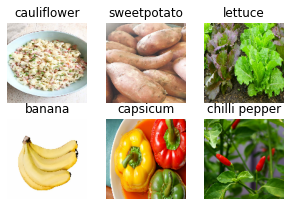

In [ ]:
# Visualize
plt.figure(figsize=(5, 5))
class_names = train_dataset.class_names
for images, labels in train_dataset.take(1):
  for i in range(6):
    if class_names[labels[i]] != "output":
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(images[i].numpy().astype("uint8"))
      plt.axis("off")
      plt.title(class_names[labels[i]])

## Augment number of images

In [ ]:
!pip install Augmentor

# Augmentor aims to be both a data augmentation tool and a library of basic image pre-processing functions
#https://neptune.ai/blog/data-augmentation-in-python

#Alternative method would have been: https://github.com/aleju/imgaug

In [ ]:
import Augmentor
p = Augmentor.Pipeline(f"{DIR}/train")

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Initialised with 2792 image(s) found.
Output directory set to /content/gdrive/My Drive/Kaggle/train/output.

In [ ]:
p.rotate(probability=1.0, max_left_rotation=5, max_right_rotation=5)
p.random_distortion(probability=0.4, grid_width=100, grid_height=100, magnitude=8)
p.skew(probability=0.4)
p.shear(probability=0.5, max_shear_left=2, max_shear_right=2)
p.flip_left_right(probability=0.4)
# p.flip_top_bottom(probability=0.4)
# p.resize(probability=1.0, width=128, height=128)

# https://github.com/mdbloice/Augmentor
# https://augmentor.readthedocs.io/en/master/code.html

In [ ]:
# Generate augmented images based on your specifications
# Selected this value because the augemented images get saved in "output" folder 
# in my Google Drive and space is limited
p.sample(100000)

Processing <PIL.Image.Image image mode=RGB size=448x375 at 0x7FBC9FFD4FD0>:   0%|          | 90/100000 [01:21<42:58:46,  1.55s/ Samples]/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
Processing <PIL.Image.Image image mode=RGB size=1280x720 at 0x7FBC96121F10>:  18%|█▊        | 18144/100000 [2:46:42<23:49:55,  1.05s/ Samples] 

In [ ]:
# p.process()
# p.status()

## Generate training, validation and test datasets

In [ ]:
# Results of augmentator are in f"{DIR}/train/output"
# https://keras.io/api/preprocessing/image/

seed = 40
labels = 'inferred' # 'inferred': labels are generated from the directory structure
label_mode = 'int' # 'int': means that the labels are encoded as integers (e.g. for sparse_categorical_crossentropy loss).
image_size = (256, 256) #documentation says default is (256,256)
batch_size = 32 # documentation says default is 32
channels = "rgb"
val_split = 0.2

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory=f"{DIR}/train/output",
    validation_split=val_split,
    subset="training",
    seed=seed,
    image_size=image_size,
    batch_size=batch_size,
    color_mode=channels,
    labels=labels,
    label_mode=label_mode,
)
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory=f"{DIR}/train/output",
    validation_split=val_split,
    subset="validation",
    seed=seed,
    image_size=image_size,
    batch_size=batch_size,
    color_mode=channels,
    labels=labels,
    label_mode=label_mode,
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory=f"{DIR}/test",
    subset=None,
    seed=seed,
    image_size=image_size,
    batch_size=batch_size,
    color_mode=channels,
    labels=labels,
    label_mode=label_mode,
)

# Found 12828 files belonging to 36 classes.
# Using 10263 files for training.
# Found 12828 files belonging to 36 classes.
# Using 2565 files for validation.

Found 18206 files belonging to 36 classes.
Using 14565 files for training.
Found 18206 files belonging to 36 classes.
Using 3641 files for validation.
Found 359 files belonging to 36 classes.


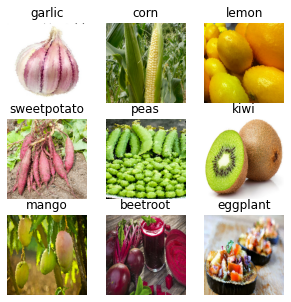

In [ ]:
# Visualize augmented output images
plt.figure(figsize=(5, 5))
class_names = train_dataset.class_names
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")
    plt.title(class_names[labels[i]])

## DenseNet Model

In [ ]:
# https://www.kaggle.com/mauricioasperti/cats-vs-dogs-image-classification/notebook
# https://www.pluralsight.com/guides/introduction-to-densenet-with-tensorflow
# https://keras.io/api/applications/densenet/
# I can compute the number 121 as follows: 5+(6+12+24+16)*2=121, where 5 is (conv,pooling)+3 transition layers+ classification layer. we multiple 2 because each dense block has 2 layers (1x1 conv and 3x3 conv).
# https://keras.io/api/layers/core_layers/dense/

model_d=DenseNet121(include_top=False,
                    weights="imagenet",                       #pre-training on ImageNet
                    input_shape=(256, 256, 3),                #given the image_size and rgb in image_dataset_from_directory
                    pooling="avg")                            # global average pooling will be applied to the output of the last convolutional block, and thus the output of the model will be a 2D tensor

x = model_d.output
x = layers.experimental.preprocessing.Rescaling(1./255)(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(1024,activation='relu')(x)
x = Dense(512,activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

pred = Dense(36, activation='softmax')(x)                        #FC-layer

model = Model(inputs=model_d.input, 
              outputs=pred)

In [ ]:
for layer in model.layers[:-32]:
    layer.trainable=False
    
for layer in model.layers[-32:]:
    layer.trainable=True

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(1e-3),
              loss="sparse_categorical_crossentropy",
              metrics=["sparse_categorical_accuracy"])
#model.summary()

In [ ]:
#callbacks
reducelearningrate = ReduceLROnPlateau(monitor='val_accuracy', 
                                       factor=0.5, 
                                       patience=5, 
                                       verbose=1,
                                       min_lr=1e-3)
modelcheckpoint = ModelCheckpoint('model.h5', 
                                  verbose=1, 
                                  save_best_only=True)
early_stopping = EarlyStopping(patience=3)

In [ ]:
history = model.fit(train_dataset,
                    epochs=50, 
                    callbacks=[reducelearningrate, 
                               modelcheckpoint, 
                               early_stopping], 
                    validation_data=val_dataset)

Epoch 1/50
456/456 [==============================] - 6144s 13s/step - loss: 2.4526 - sparse_categorical_accuracy: 0.3310 - val_loss: 2.5551 - val_sparse_categorical_accuracy: 0.3051

Epoch 00001: val_loss improved from inf to 2.55505, saving model to model.h5
Epoch 2/50
456/456 [==============================] - 330s 717ms/step - loss: 1.6217 - sparse_categorical_accuracy: 0.5177 - val_loss: 1.0762 - val_sparse_categorical_accuracy: 0.6751

Epoch 00002: val_loss improved from 2.55505 to 1.07624, saving model to model.h5
Epoch 3/50
456/456 [==============================] - 330s 719ms/step - loss: 1.2726 - sparse_categorical_accuracy: 0.6094 - val_loss: 0.9244 - val_sparse_categorical_accuracy: 0.7119

Epoch 00003: val_loss improved from 1.07624 to 0.92438, saving model to model.h5
Epoch 4/50
456/456 [==============================] - 324s 704ms/step - loss: 1.0687 - sparse_categorical_accuracy: 0.6660 - val_loss: 0.7656 - val_sparse_categorical_accuracy: 0.7536

Epoch 00004: val_loss 

In [ ]:
loss, accuracy = model.evaluate(train_dataset)
print(f"Loss: {loss}\tAccuracy: {accuracy}")

456/456 [==============================] - 254s 552ms/step - loss: 0.1084 - sparse_categorical_accuracy: 0.9653
Loss: 0.10837524384260178	Accuracy: 0.9652591943740845


In [ ]:
loss, accuracy = model.evaluate(val_dataset)
print(f"Loss: {loss}\tAccuracy: {accuracy}")

114/114 [==============================] - 65s 549ms/step - loss: 0.3936 - sparse_categorical_accuracy: 0.8923
Loss: 0.39359527826309204	Accuracy: 0.8923372626304626


In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print(f"Loss: {loss}\tAccuracy: {accuracy}")

12/12 [==============================] - 178s 3s/step - loss: 0.2997 - sparse_categorical_accuracy: 0.9109
Loss: 0.2996748685836792	Accuracy: 0.9108635187149048


In [ ]:
from sklearn.metrics import confusion_matrix

y_pred_val = model.predict(val_dataset)
y_test_val = np.concatenate([y for x, y in val_dataset], axis=0)

y_pred = model.predict(test_dataset)
y_test = np.concatenate([y for x, y in test_dataset], axis=0)

In [ ]:
cm_val = confusion_matrix(y_test_val, np.argmax(y_pred_val, axis=1))
cm = confusion_matrix(y_test, np.argmax(y_pred, axis=1))

In [ ]:
print(y_test, "\n\n")
print(np.argmax(y_pred, axis=1))

[16  5 26 24 19  9  6 12 22 23 32 20  8 19 18 18 25 18 15  4  2 21 23  5
  3 12 34  5 25 30  9 30 10 28  3 27 13 10 26 28 25 25 18  1 19  5  2 13
 16 32  6 30  5 31 21 23 20  0  9 14  3 16  7 34 24 31  6 26  3 33 17 19
  6 15 25  8 30 33 29 30 13 34 11 28 35  0 24 34  1 27 32  8 29  9  2 23
 24  0  5 10 16 18 25  1 10  7  7 15  1  3  6 12 25  8 18  4 29 33 32 35
 27 33 15 18  9  8 32 21  0 25  1  9 14 27 14 22 28  3 13  4 16  1 27 34
 12  2 31 23 28  4 15  2  0 11  8 26 20 22  4 12  2  8  1 20 13 19 31 30
 11  6 35 34 17  4 31 12  9 28 21 32 27 29  9 35 30 23 26  7  0 20 16  8
 14 17 33 14  5  3 24 31  0 32 17 15 26 14 26  7 17 19 22  8 31 21 32 21
 34 32  5 11 29  9  1 23 35  5 13 21 11 35 29 11  3 14  2 27  1 19  4 28
 15 11 18 34 14 12 22 24 12  2 18 28 28 23 16  6 29 17 15 30  4 14 22 10
 12 35 22 11 17 24  6  9  2  7 24  6 28 18 20 31 23  0 34 34  4 20  5 16
 19 30 17  3 11 24  3 27 33 13 26 33 17 23 35 33 33 21  7 20  7 35 29  2
 10 24  7  6 20 15 10 27 12 16 11 21 17 19  8 33  0

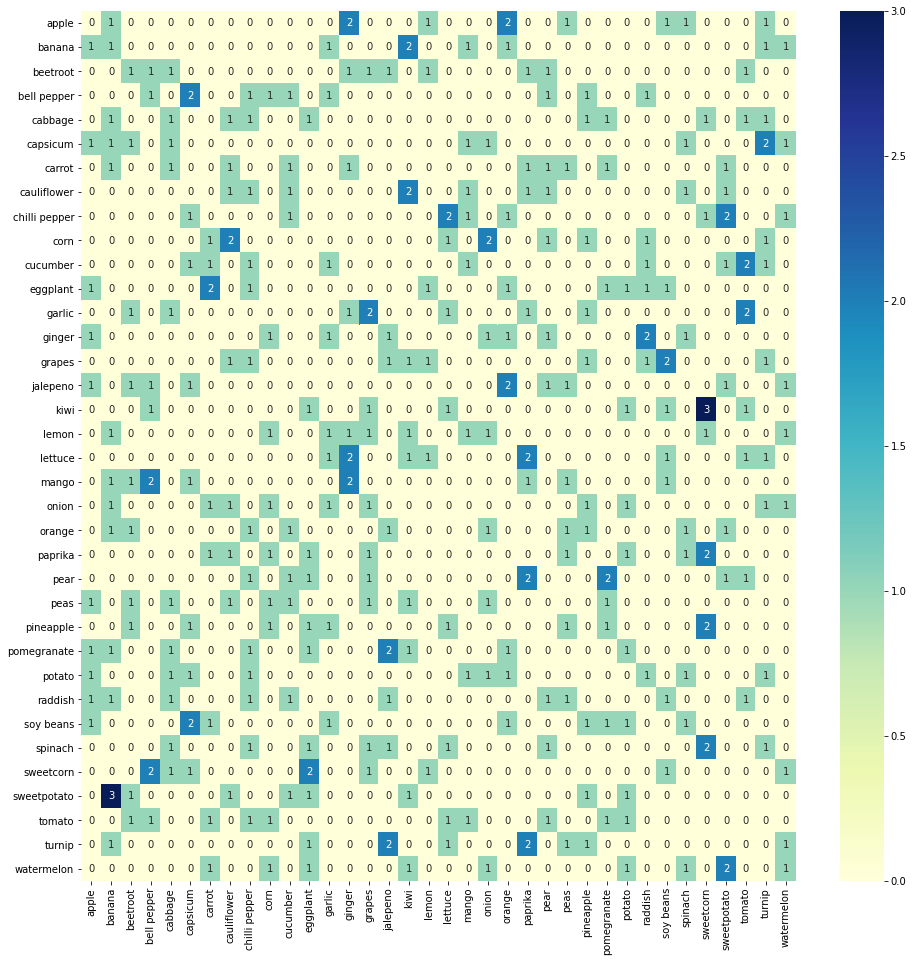

In [ ]:
import seaborn as sns
plt.figure(figsize=(16, 16))
ax = sns.heatmap(cm, cmap="YlGnBu", annot=True, 
                 xticklabels=train_folder_names, 
                 yticklabels=train_folder_names)

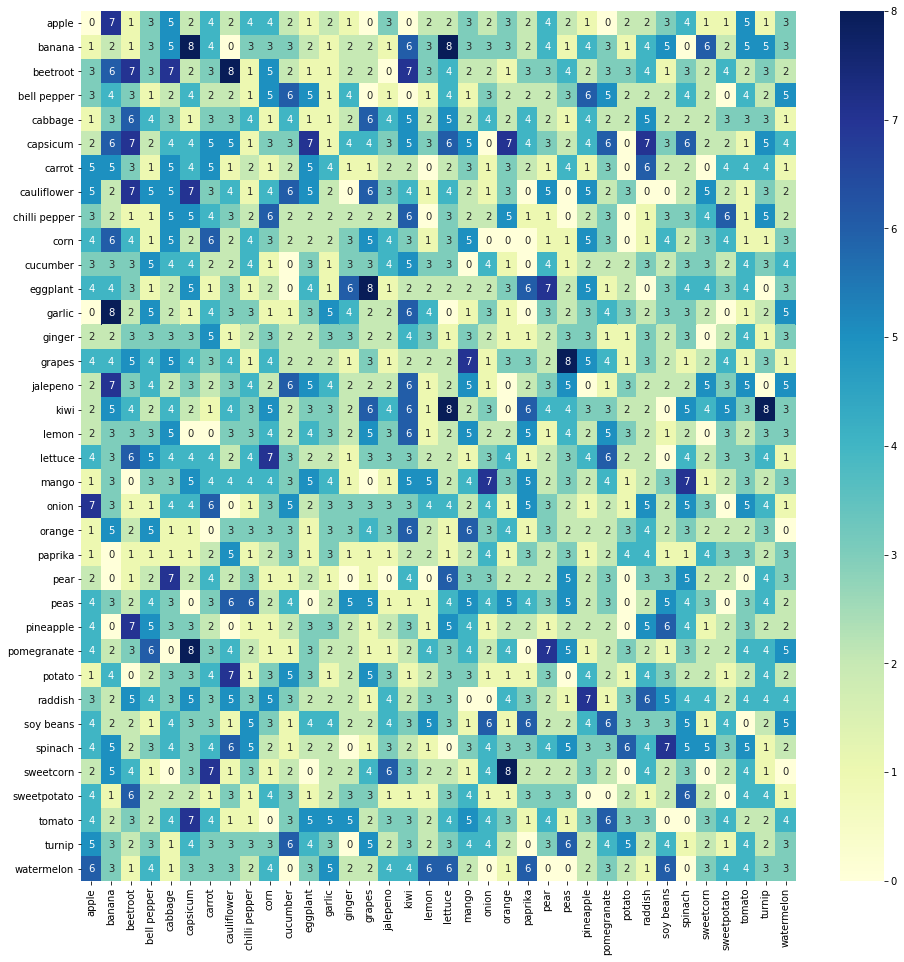

In [ ]:
plt.figure(figsize=(16, 16))
ax = sns.heatmap(cm_val, cmap="YlGnBu", annot=True, xticklabels=train_folder_names, yticklabels=train_folder_names)

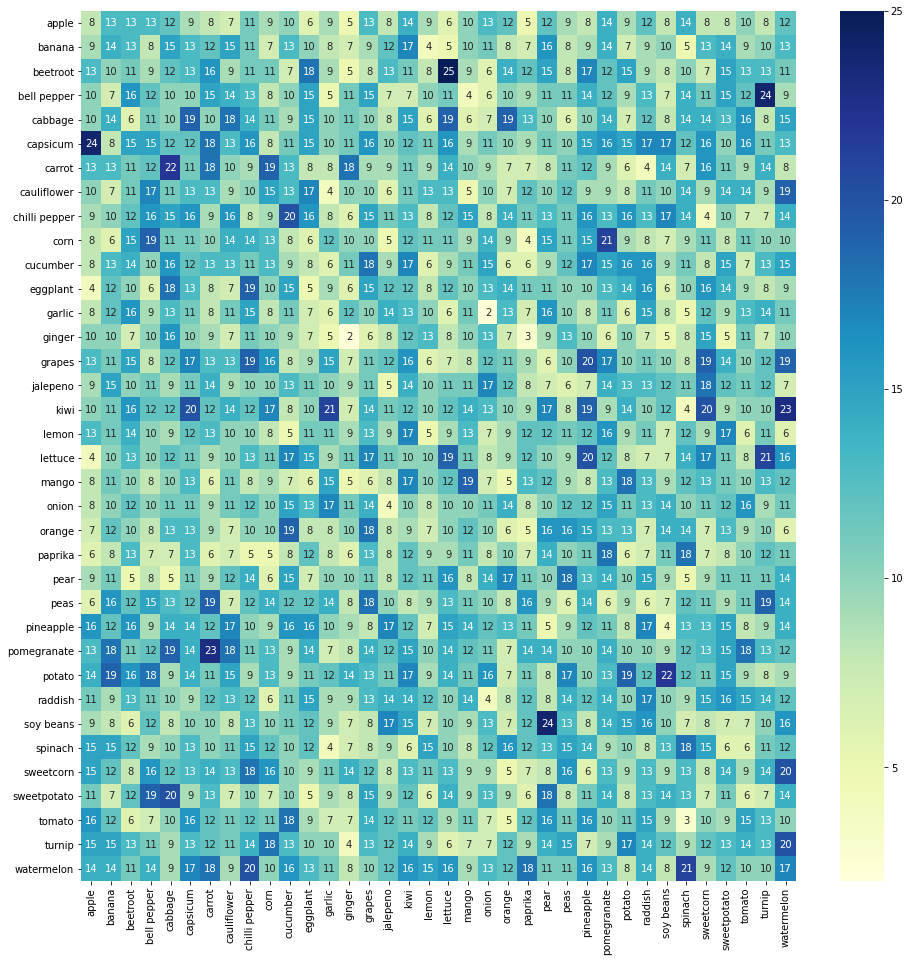

In [ ]:
y_pred_train = model.predict(train_dataset)
y_test_train = np.concatenate([y for x, y in train_dataset], axis=0)

cm_train = confusion_matrix(y_test_train, np.argmax(y_pred_train, axis=1))

plt.figure(figsize=(16, 16))
ax = sns.heatmap(cm_train, cmap="YlGnBu", annot=True, xticklabels=train_folder_names, yticklabels=train_folder_names)